# Imports

In [ ]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figuresd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Download and organize the dataset (No Code required here)

In [ ]:
from sklearn.datasets import fetch_openml
X_df, y_df = fetch_openml('mnist_784',version=1,cache=True,return_X_y=True)
X = X_df.values
y = y_df.values.astype(np.uint8)

# Define a function that takes a list of images then samples 16 iamges from the list, then draws them using matplotlib in a 4x4 grid

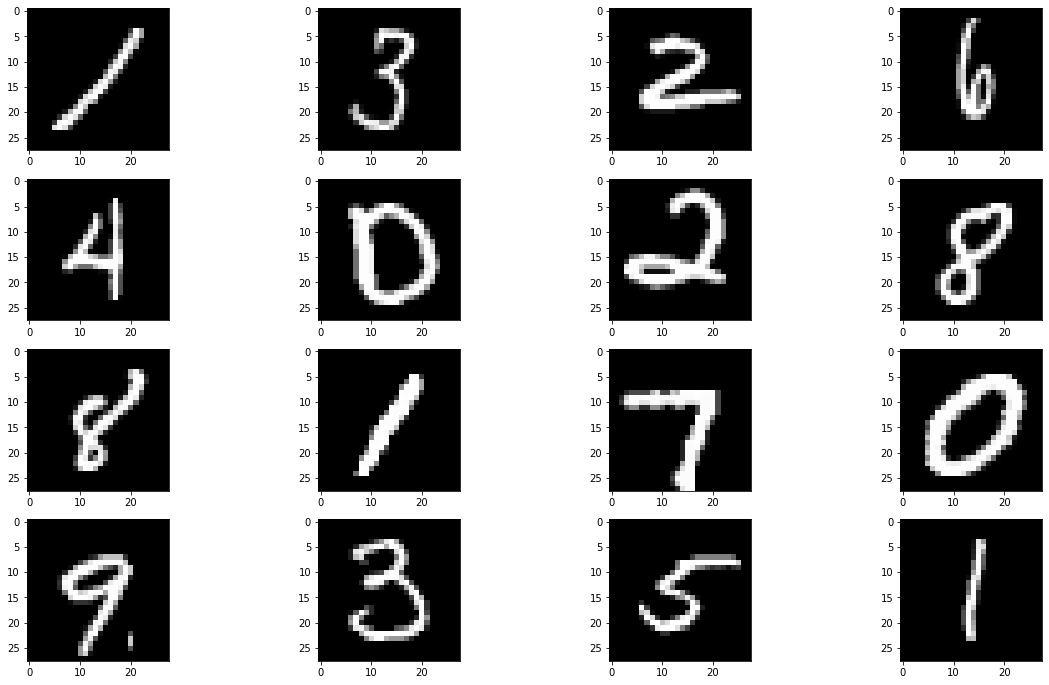

In [ ]:
import random # u may need this library
random.seed(100) # set a seed in case you want your experiments to be consistent

 
def draw_func(Array_of_imgs):
  fig, axs = plt.subplots(4, 4,figsize=(20, 12))

  for ax in axs.flatten(): 
    img_sample = Array_of_imgs[random.randint(0,Array_of_imgs.shape[0]-1), :]
    img_sample = img_sample.reshape(28,28)
    ax.imshow(img_sample, cmap=plt.cm.gray)

  plt.show()

## Test your function using the read images here
draw_func(X)
##


# Count number of white pixels

In [ ]:
[np.sum(img>128)/(28*28) for img in X]


X[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [ ]:
Feature_num_white = [np.sum(img>128)/784 for img in X]
Feature_num_white = np.array(Feature_num_white)
print(Feature_num_white.mean(), Feature_num_white.std(), Feature_num_white.min(), Feature_num_white.max())

0.1309325437317784 0.04363825027341309 0.01913265306122449 0.3979591836734694


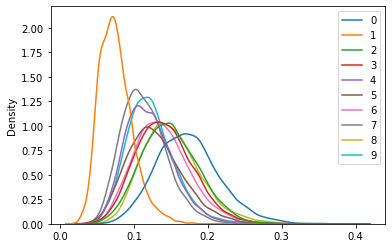

In [ ]:
import seaborn as sns
sns.kdeplot(Feature_num_white ,hue = y, palette= sns.color_palette())

# Apply Gaussian derivative over the images

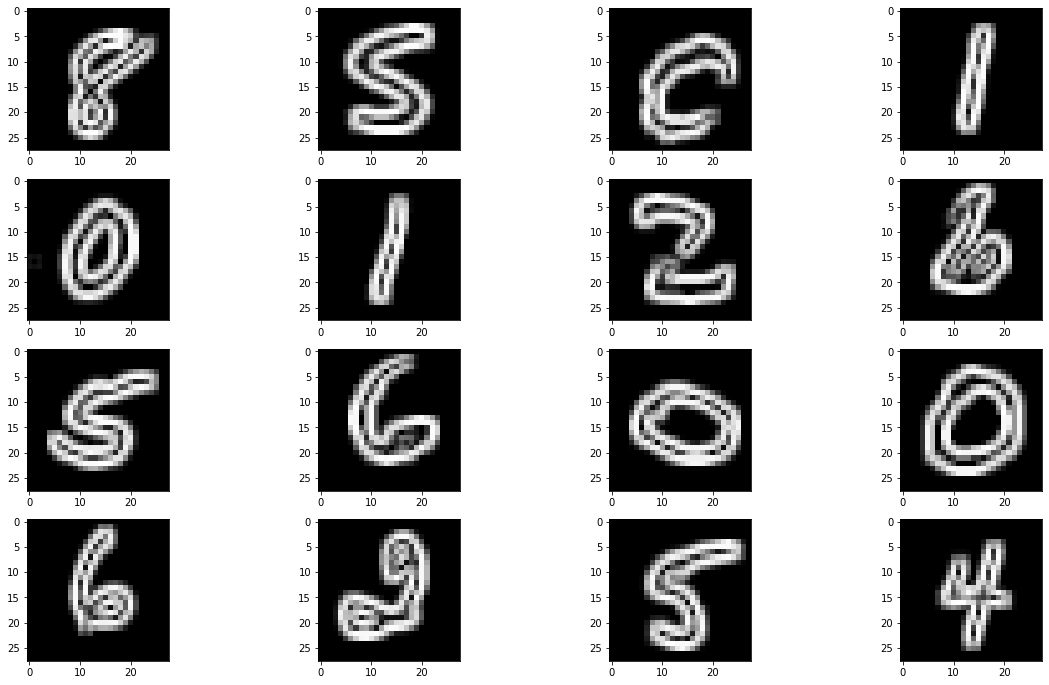

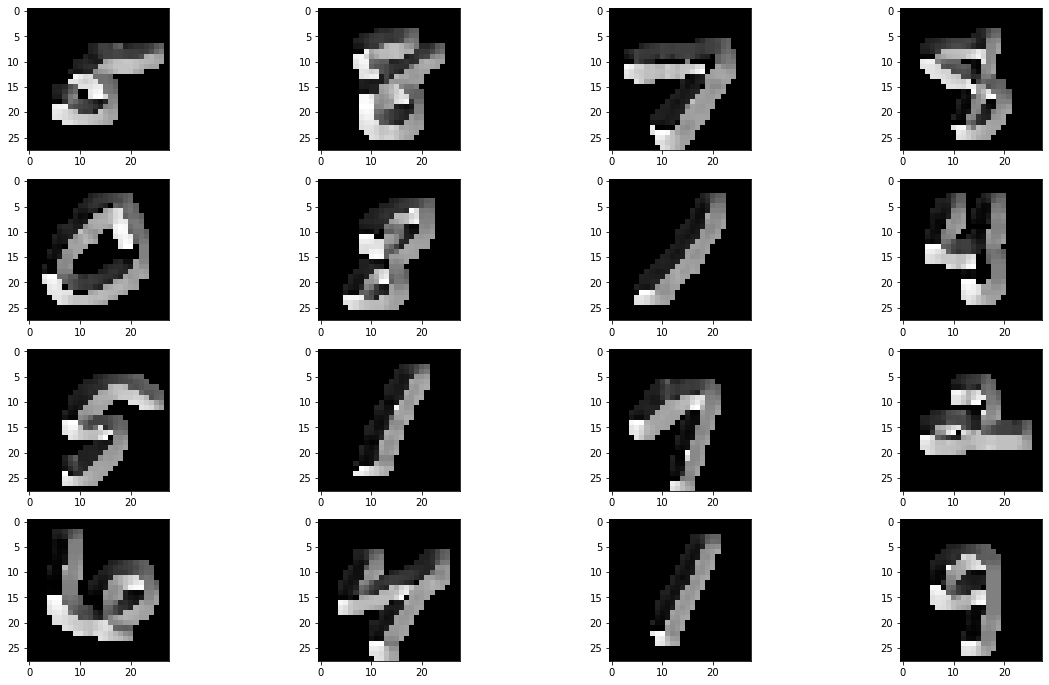

In [ ]:
import scipy.ndimage
import math

weights = np.zeros((9, 9))
weights[4,4] = 1.0
gaussF = scipy.ndimage.filters.gaussian_filter(weights, 0.1, order=0,truncate=3.0)

#Sobel mask in x
weights = np.zeros((3,3))
weights[:,0] = -np.ones((3,)) 
weights[:,2] = np.ones((3,)) 
DoGx = scipy.ndimage.convolve(gaussF, weights)

#Sobel mask in y
weights = np.zeros((3,3))
weights[0,:] = np.ones((3,)) 
weights[2,:] = -np.ones((3,)) 
DoGy = scipy.ndimage.convolve(gaussF, weights)

devX = [scipy.ndimage.convolve(img, DoGx) for img in X.reshape(-1,28,28)] # Derivative in the X direction
devY = [scipy.ndimage.convolve(img, DoGy) for img in X.reshape(-1,28,28)] # Derivative in the Y direction

mag_imgs   = np.array([np.sqrt(np.square(devx) + np.square(devy)) for devx, devy in zip(devX, devY)])
angle_imgs = np.array([np.arctan2(-devy,devx) + math.pi           for devx, devy in zip(devX, devY)])

for angle, mag in zip(angle_imgs, mag_imgs):
  non_edge_indices = mag<0.5 # include only the edges with high gradients
  angle[non_edge_indices] = 0

# Use your draw function to visualize the magnitude
draw_func(mag_imgs)

# Use your draw function to visualize the orientation
draw_func(angle_imgs)

# Histogram of edges

In [ ]:
actual_angles = []
for angle, mag in zip(angle_imgs, mag_imgs):
  mag_flat = mag.flatten()
  angle_flat = angle.flatten()
  
  indices = np.where(mag_flat>=0.5)[0]
  actual_angles_for_image = angle_flat[indices]/(2*math.pi)
  actual_angles.append(actual_angles_for_image)

bins = np.array(range(19))/18
Feature_edges_hist = [np.histogram(angle, bins=bins)[0] for angle in actual_angles]
Feature_edges_hist = np.array(Feature_edges_hist)

In [ ]:
Feature_edges_hist

array([[ 3,  3, 31, ..., 27, 13,  5],
       [27, 16, 49, ...,  8,  5,  9],
       [34, 14, 16, ...,  7,  7,  6],
       ...,
       [16, 39, 30, ..., 12,  6,  7],
       [11, 14, 18, ..., 15,  6,  6],
       [14, 20, 51, ..., 22,  7,  5]])

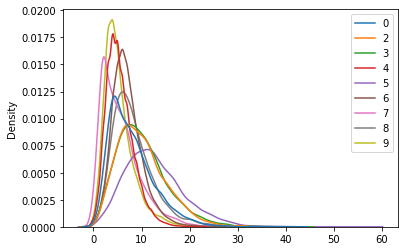

In [ ]:
# sns.kdeplot([edge[3] for edge in Feature_edges_hist] ,hue = y, palette= sns.color_palette())
sns.kdeplot([edge[5] for edge in Feature_edges_hist[y!=1]] ,hue = y[y!=1], palette= sns.color_palette(n_colors=9))


# Your Turn

*   Apply model before feature extraction.
*   Apply model after feature extraction.
*   Try to enchance accuracy using at least 2 more features

Research:

*   Harris corner detector





# model before feature extraction.





In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
import time
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

start = time.time()
model = LGBMClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
stop = time.time()

print("Total time is : ", stop - start)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2058
           1       0.98      0.98      0.98      2364
           2       0.96      0.97      0.97      2133
           3       0.97      0.96      0.96      2176
           4       0.96      0.97      0.97      1936
           5       0.98      0.97      0.97      1915
           6       0.98      0.98      0.98      2088
           7       0.97      0.97      0.97      2248
           8       0.96      0.96      0.96      1992
           9       0.94      0.95      0.95      2090

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000

204.89517188072205


# model after feature extraction.





### Magnitude Images





In [ ]:
mag_imgs = mag_imgs.reshape(70000, 28*28)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mag_imgs, y, test_size=0.30, random_state=42)

In [ ]:
mag_imgs.shape

(70000, 784)

In [ ]:
import time
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

start = time.time()
model = LGBMClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
stop = time.time()

print("Total time is : ", stop - start)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2058
           1       0.98      0.98      0.98      2364
           2       0.96      0.96      0.96      2133
           3       0.94      0.94      0.94      2176
           4       0.96      0.96      0.96      1936
           5       0.98      0.94      0.96      1915
           6       0.97      0.98      0.97      2088
           7       0.97      0.96      0.97      2248
           8       0.93      0.94      0.93      1992
           9       0.94      0.95      0.94      2090

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000

Total time is :  282.1683979034424


### Angle Images





In [ ]:
angle_imgs = angle_imgs.reshape(70000, 28*28)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(angle_imgs, y, test_size=0.30, random_state=42)

In [ ]:
angle_imgs.shape

(70000, 784)

In [ ]:
import time
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

start = time.time()
model = LGBMClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
stop = time.time()

print("Total time is : ", stop - start)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2058
           1       0.99      0.99      0.99      2364
           2       0.96      0.98      0.97      2133
           3       0.98      0.96      0.97      2176
           4       0.98      0.98      0.98      1936
           5       0.98      0.98      0.98      1915
           6       0.98      0.98      0.98      2088
           7       0.98      0.98      0.98      2248
           8       0.97      0.96      0.97      1992
           9       0.96      0.97      0.96      2090

    accuracy                           0.98     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.98      0.98      0.98     21000

Total time is :  276.7845299243927


# first feature extraction Harris corner detector





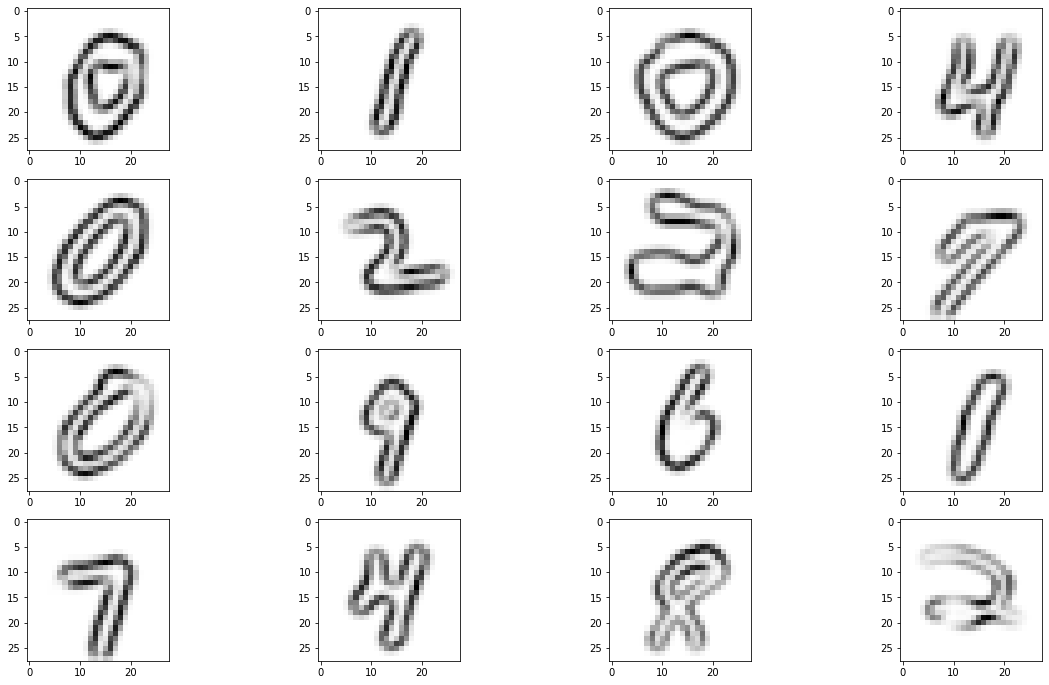

In [ ]:
import cv2
cornerHarrisImgs = []

for i in range(len(X)):
  img = np.float32(X[i].reshape(28,28))
  cornerHarrisImgs.append(cv2.cornerHarris(img, 2, 5, 0.85))

cornerHarrisImgs = np.array(cornerHarrisImgs)

draw_func(cornerHarrisImgs)

In [ ]:
cornerHarrisImgs = cornerHarrisImgs.reshape(70000,28*28)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(cornerHarrisImgs, y, test_size=0.30, random_state=42)

In [ ]:
import time
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

start = time.time()
model = LGBMClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
stop = time.time()

print("Total time is : ", stop - start)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2058
           1       0.99      0.98      0.98      2364
           2       0.96      0.97      0.96      2133
           3       0.96      0.95      0.95      2176
           4       0.96      0.97      0.96      1936
           5       0.97      0.95      0.96      1915
           6       0.97      0.97      0.97      2088
           7       0.97      0.97      0.97      2248
           8       0.93      0.94      0.94      1992
           9       0.94      0.95      0.95      2090

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000

Total time is :  369.8186354637146


# second feature extraction adaptive gaussian thresholding




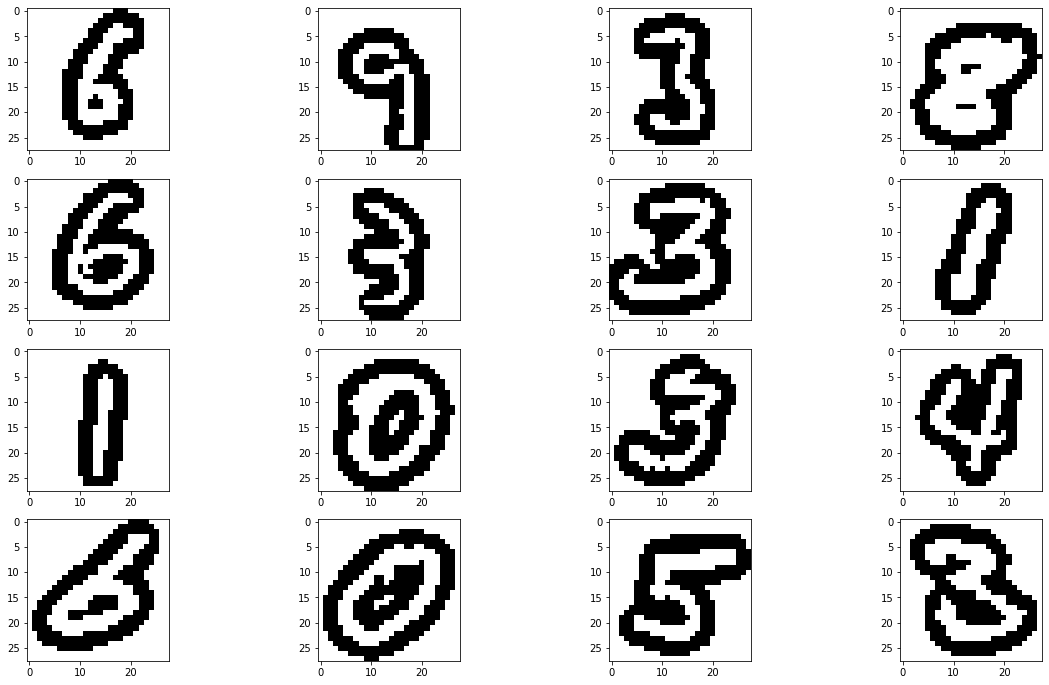

In [ ]:
import cv2
from skimage import img_as_ubyte

adaptive_gaussian_Imgs= []

for i in range(len(X)):
  img = np.float32(X[i].reshape(28,28))/255
  img = img_as_ubyte(img)
  adaptive_gaussian_Imgs.append(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,3))

adaptive_gaussian_Imgs = np.array(adaptive_gaussian_Imgs)

draw_func(adaptive_gaussian_Imgs)

In [ ]:
adaptive_gaussian_Imgs = adaptive_gaussian_Imgs.reshape(70000,28*28)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(adaptive_gaussian_Imgs, y, test_size=0.30, random_state=42)

In [ ]:
import time
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

start = time.time()
model = LGBMClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
stop = time.time()

print("Total time is : ", stop - start)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2058
           1       0.98      0.98      0.98      2364
           2       0.95      0.96      0.95      2133
           3       0.96      0.95      0.96      2176
           4       0.96      0.97      0.97      1936
           5       0.97      0.97      0.97      1915
           6       0.97      0.97      0.97      2088
           7       0.97      0.97      0.97      2248
           8       0.96      0.94      0.95      1992
           9       0.95      0.94      0.95      2090

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000

Total time is :  264.5800259113312
